<a href="https://colab.research.google.com/github/TitusChoi/Novelist_Classification/blob/titus/Novelist_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import warnings 
warnings.filterwarnings(action='ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re
import random

In [4]:
#경로 설정
import os
os.chdir('./')

In [5]:
#파일 불러오기
train = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/train.csv', encoding = 'utf-8')
train_new = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/test_x.csv', encoding = 'utf-8')
test_new = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_test.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/sample_submission.csv', encoding = 'utf-8')
sample_submission_new = pd.read_csv('/content/drive/MyDrive/Novelist_Classification/datasets/new_sample_submission.csv', encoding = 'utf-8')

In [6]:
#train 데이터 살펴보기
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [7]:
train_new

,Unnamed: 0,text,author
0,0,It is hard to forget repulsive things. I remem...,6
1,1,It would be tedious if given in the beadle’s w...,7
2,2,“Very good. Shall we argue about it here in p...,2
3,3,“What! and I as high as a tree and as big as a...,6
4,4,"""Isn't it enough, Vanya?"" she cried, seeing hi...",3
...,...,...,...
83215,83215,"What with the birthday visitors, and what with...",7
83216,83216,It was an old rickety door and gave at once be...,2
83217,83217,"“Well then you can go to the devil,” said odin...",3
83218,83218,“Don’t know?”,7


In [8]:
#test 데이터 살펴보기
del test_new['Unnamed: 0']
test_new

,index,text
0,0,"About thirty years ago Miss Maria Ward, of Hun..."
1,1,"Their homes were so distant, and the circles i..."
2,2,The letter was not unproductive. It re-establi...
3,3,"Such were its immediate effects, and within a ..."
4,4,Sir Thomas could not give so instantaneous and...
...,...,...
27313,27313,"At the end of another day or two, odin growing..."
27314,27314,"All afternoon we sat together, mostly in silen..."
27315,27315,"odin, having carried his thanks to odin, proc..."
27316,27316,"Soon after this, upon odin's leaving the room,..."


In [9]:
#sample_submission
del sample_submission_new['Unnamed: 0']
sample_submission_new = sample_submission_new.drop(sample_submission_new.index[27318])
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
27313,27313,0,0,0,0,0,0,0,0
27314,27314,0,0,0,0,0,0,0,0
27315,27315,0,0,0,0,0,0,0,0
27316,27316,0,0,0,0,0,0,0,0


# **전처리**

In [10]:
#부호를 제거해주는 함수
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

train['text']=train['text'].apply(alpha_num)

In [11]:
# 불용어 제거해주는 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in base_stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
base_stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [12]:
#전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)


train_new['text'] = train_new['text'].str.lower()
test_new['text'] = test_new['text'].str.lower()
train_new['text'] = train_new['text'].apply(alpha_num).apply(remove_stopwords)
test_new['text'] = test_new['text'].apply(alpha_num).apply(remove_stopwords)

In [13]:
# train test 분리
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])

X_train_new = np.array([x for x in train_new['text']])
X_test_new = np.array([x for x in test_new['text']])
y_train_new = np.array([x for x in train_new['author']])

# **모델링**

In [14]:
# FastText 사용
import gensim
from gensim.models.keyedvectors import KeyedVectors

In [15]:
pip install -U gensim

     |████████████████████████████████| 23.9MB 63.5MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [17]:
FastText = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Novelist_Classification/embbeding/fasttext.vec')

ValueError: ignored

In [21]:
#파라미터 설정
vocab_size = 47136
vocab_size_new = 63727
embedding_dim = 16
max_length = 500
padding_type='post'
#oov_tok = "<OOV>"

In [22]:
#tokenizer에 fit
# 작가 5명
tokenizer = Tokenizer(num_words = vocab_size)#, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# 작가 8명
tokenizer_new = Tokenizer(num_words = vocab_size_new)#, oov_token=oov_tok)
tokenizer_new.fit_on_texts(X_train_new)
word_index_new = tokenizer_new.word_index

In [23]:
len(word_index_new)

63727

In [24]:
# Fasttext 임베딩 과정
FT_embedding_matrix = np.zeros((vocab_size,100))
FT_embedding_matrix_new = np.zeros((vocab_size_new,100))

def get_vector(word):
    if word in FastText:
        return FastText[word]
    else:
        return None

# 작가5명
for word, idx in word_index.items():
    temp = get_vector(word)
    if temp is not None:
        FT_embedding_matrix[idx] = temp

# 작가8명
for word, idx in word_index_new.items():
    temp = get_vector(word)
    if temp is not None:
        FT_embedding_matrix_new[idx] = temp

NameError: ignored

In [25]:
# 사전 학습된 glove 불러오고 임베딩 층에 적용시키기 
embedding_dict= dict()
f = open('/content/drive/MyDrive/Novelist_Classification/embbeding/glove.txt', encoding='utf8')

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close

g_embedding_matrix = np.zeros((vocab_size, 50))
g_embedding_matrix_new = np.zeros((vocab_size_new+1, 50))

# 작가5명
for word, i in word_index.items():
    temp = embedding_dict.get(word)
    if temp is not None:
        g_embedding_matrix[i] = temp

# 작가8명
for word, i in word_index_new.items():
    temp = embedding_dict.get(word)
    if temp is not None:
        g_embedding_matrix_new[i] = temp

#GRU 모델

In [26]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

train_sequences_new = tokenizer.texts_to_sequences(X_train_new)
train_padded_new = pad_sequences(train_sequences_new, padding=padding_type, maxlen=max_length)

test_sequences_new = tokenizer.texts_to_sequences(X_test_new)
test_padded_new = pad_sequences(test_sequences_new, padding=padding_type, maxlen=max_length)

In [27]:
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dropout,Dense, Conv1D, GlobalMaxPool1D, concatenate, MaxPool1D
import time
import matplotlib.pyplot as plt

In [28]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size
VOCAB_SIZE_new = vocab_size_new

커널 사이즈 3,4,5를 각각 거친후 GlobalMaxPool1D 실행후 concat으로 합치기<br>
FaseText 작가 5명

In [29]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 100,weights = [FT_embedding_matrix], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [30]:
conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

In [31]:
# 3, 4, 5 - gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [32]:
model_fast_org = Model(inputs=input_layer,outputs=predictions)
model_fast_org.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_fast_org = model_fast_org.fit(train_padded,y_train,verbose=2, epochs=EPOCH,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 108s - loss: 1.5728 - accuracy: 0.2734 - val_loss: 1.5715 - val_accuracy: 0.2680
Epoch 2/30
1372/1372 - 77s - loss: 1.5702 - accuracy: 0.2761 - val_loss: 1.5715 - val_accuracy: 0.2680
Epoch 3/30
1372/1372 - 75s - loss: 1.5702 - accuracy: 0.2761 - val_loss: 1.5714 - val_accuracy: 0.2680
Epoch 4/30
1372/1372 - 74s - loss: 1.5702 - accuracy: 0.2761 - val_loss: 1.5715 - val_accuracy: 0.2680
Epoch 5/30
1372/1372 - 74s - loss: 1.5702 - accuracy: 0.2761 - val_loss: 1.5719 - val_accuracy: 0.2680
Epoch 6/30
1372/1372 - 75s - loss: 1.5701 - accuracy: 0.2761 - val_loss: 1.5711 - val_accuracy: 0.2680
Epoch 7/30
1372/1372 - 75s - loss: 1.5700 - accuracy: 0.2761 - val_loss: 1.5714 - val_accuracy: 0.2680
Epoch 8/30
1372/1372 - 75s - loss: 1.5702 - accuracy: 0.2761 - val_loss: 1.5714 - val_accuracy: 0.2680
Epoch 9/30
1372/1372 - 74s - loss: 1.5702 - accuracy: 0.2761 - val_loss: 1.5714 - val_accuracy: 0.2680
Epoch 10/30
1372/1372 - 75s - loss: 1.5702 - accuracy: 0.2761 - val_loss

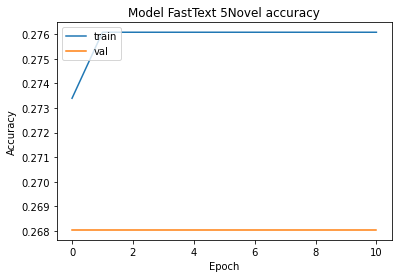

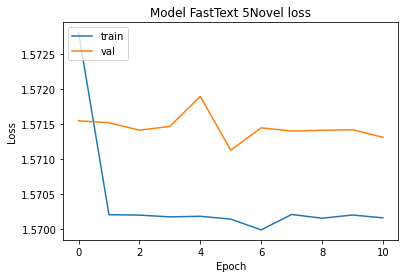

In [34]:
plt.plot(hist_fast_org.history['accuracy'])
plt.plot(hist_fast_org.history['val_accuracy'])
plt.title('Model FastText 5Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_org.history['loss'])
plt.plot(hist_fast_org.history['val_loss'])
plt.title('Model FastText 5Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [35]:
pred_fast_org = model_fast_org.predict(test_padded)
sample_submission[['0','1','2','3','4']] = pred_fast_org
sample_submission

,index,0,1,2,3,4
0,0,0.240228,0.13298,0.212198,0.267359,0.147236
1,1,0.240228,0.13298,0.212198,0.267359,0.147236
2,2,0.240228,0.13298,0.212198,0.267359,0.147236
3,3,0.240228,0.13298,0.212198,0.267359,0.147236
4,4,0.240228,0.13298,0.212198,0.267359,0.147236
...,...,...,...,...,...,...
19612,19612,0.240228,0.13298,0.212198,0.267359,0.147236
19613,19613,0.240228,0.13298,0.212198,0.267359,0.147236
19614,19614,0.240228,0.13298,0.212198,0.267359,0.147236
19615,19615,0.240228,0.13298,0.212198,0.267359,0.147236


In [ ]:
model_fast_org.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_fast_org.h5')

커널 사이즈 3,4,5를 각각 거친후 GlobalMaxPool1D 실행후 concat으로 합치기 <br>
FastText 작가 8명


In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size_new, 100,weights = [FT_embedding_matrix_new], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [ ]:
conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

In [ ]:
# 3, 4, 5 - gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(8, name='logits')(dropout_hidden)
predictions = Dense(8, activation=tf.nn.softmax)(logits)

In [ ]:
model_fast_new = Model(inputs=input_layer,outputs=predictions)
model_fast_new.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_fast_new = model_fast_new.fit(train_padded_new,y_train_new, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
2081/2081 - 130s - loss: 1.9868 - accuracy: 0.2168 - val_loss: 1.6920 - val_accuracy: 0.3522
Epoch 2/30
2081/2081 - 129s - loss: 1.5603 - accuracy: 0.4053 - val_loss: 1.2979 - val_accuracy: 0.5135
Epoch 3/30
2081/2081 - 129s - loss: 1.2362 - accuracy: 0.5330 - val_loss: 1.1415 - val_accuracy: 0.5676
Epoch 4/30
2081/2081 - 129s - loss: 1.0423 - accuracy: 0.6057 - val_loss: 1.0664 - val_accuracy: 0.5928
Epoch 5/30
2081/2081 - 127s - loss: 0.9253 - accuracy: 0.6501 - val_loss: 1.0296 - val_accuracy: 0.6191
Epoch 6/30
2081/2081 - 127s - loss: 0.8364 - accuracy: 0.6800 - val_loss: 1.0280 - val_accuracy: 0.6248
Epoch 7/30
2081/2081 - 126s - loss: 0.7706 - accuracy: 0.7049 - val_loss: 0.9979 - val_accuracy: 0.6372
Epoch 8/30
2081/2081 - 126s - loss: 0.7264 - accuracy: 0.7181 - val_loss: 1.0382 - val_accuracy: 0.6182
Epoch 9/30
2081/2081 - 126s - loss: 0.6840 - accuracy: 0.7336 - val_loss: 1.0904 - val_accuracy: 0.6147
Epoch 10/30
2081/2081 - 126s - loss: 0.6530 - accuracy: 0.7425 -

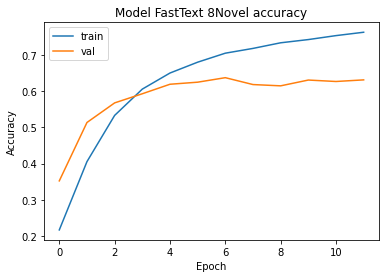

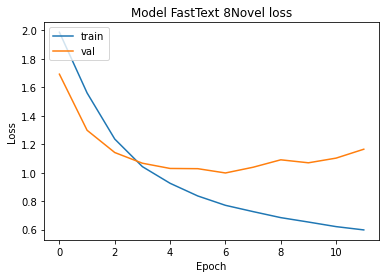

In [ ]:
plt.plot(hist_fast_new.history['accuracy'])
plt.plot(hist_fast_new.history['val_accuracy'])
plt.title('Model FastText 8Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_new.history['loss'])
plt.plot(hist_fast_new.history['val_loss'])
plt.title('Model FastText 8Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_fast_new = model_fast_new.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_fast_new
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,1.660067e-09,2.153196e-01,3.452292e-07,3.982781e-08,4.391035e-10,7.846782e-01,1.701444e-06,4.018415e-08
1,1,1.159880e-05,6.064726e-01,5.901470e-02,7.813841e-03,6.348841e-05,3.114192e-01,1.515305e-02,5.174567e-05
2,2,2.688417e-07,5.133784e-02,1.070626e-07,1.749263e-07,3.748618e-09,9.486498e-01,5.208918e-06,6.566359e-06
3,3,1.223216e-06,6.182856e-02,1.352993e-06,8.501377e-07,5.710002e-08,9.380985e-01,4.326327e-05,2.620064e-05
4,4,1.683798e-02,2.597826e-05,3.343221e-06,5.737178e-07,5.740763e-05,1.422555e-03,7.708211e-03,9.739439e-01
...,...,...,...,...,...,...,...,...,...
27313,27313,3.173018e-08,9.999992e-01,1.111385e-08,8.630598e-07,6.164220e-10,4.883155e-08,2.082737e-17,2.424035e-13
27314,27314,3.004895e-07,1.114529e-14,1.203667e-05,5.643258e-12,9.936978e-01,2.245320e-15,6.281432e-03,8.478477e-06
27315,27315,5.644668e-11,9.999964e-01,2.571731e-10,4.593483e-09,1.223635e-12,3.614564e-06,7.067808e-17,1.416254e-14
27316,27316,4.883537e-04,9.993437e-01,1.764535e-05,1.401769e-04,9.592385e-06,5.206282e-07,4.187831e-13,1.387022e-08


In [ ]:
model_fast_new.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_fast_new.h5')

커널 사이즈 3,4,5를 각각 거친후 GlobalMaxPool1D 실행후 concat으로 합치기<br>
glove 작가 5명


In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size, 50,weights = [g_embedding_matrix], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [ ]:
conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

In [ ]:
# 3, 4, 5 - gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

In [ ]:
model_glove_org = Model(inputs=input_layer,outputs=predictions)
model_glove_org.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_glove_org = model_glove_org.fit(train_padded,y_train, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 36s - loss: 1.5201 - accuracy: 0.3268 - val_loss: 1.3280 - val_accuracy: 0.4455
Epoch 2/30
1372/1372 - 34s - loss: 1.3222 - accuracy: 0.4530 - val_loss: 1.1072 - val_accuracy: 0.5714
Epoch 3/30
1372/1372 - 34s - loss: 1.1739 - accuracy: 0.5309 - val_loss: 1.0081 - val_accuracy: 0.6060
Epoch 4/30
1372/1372 - 34s - loss: 1.0649 - accuracy: 0.5857 - val_loss: 0.9105 - val_accuracy: 0.6529
Epoch 5/30
1372/1372 - 34s - loss: 0.9795 - accuracy: 0.6244 - val_loss: 0.8596 - val_accuracy: 0.6771
Epoch 6/30
1372/1372 - 35s - loss: 0.9085 - accuracy: 0.6548 - val_loss: 0.8369 - val_accuracy: 0.6880
Epoch 7/30
1372/1372 - 34s - loss: 0.8529 - accuracy: 0.6817 - val_loss: 0.8005 - val_accuracy: 0.7034
Epoch 8/30
1372/1372 - 34s - loss: 0.8040 - accuracy: 0.6995 - val_loss: 0.7654 - val_accuracy: 0.7150
Epoch 9/30
1372/1372 - 35s - loss: 0.7518 - accuracy: 0.7224 - val_loss: 0.7582 - val_accuracy: 0.7223
Epoch 10/30
1372/1372 - 37s - loss: 0.7165 - accuracy: 0.7358 - val_loss:

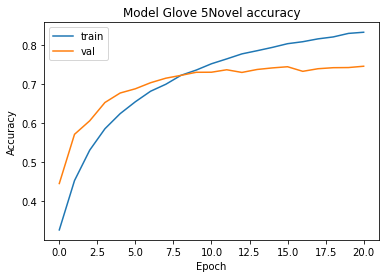

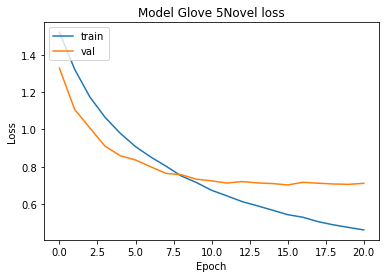

In [ ]:
plt.plot(hist_glove_org.history['accuracy'])
plt.plot(hist_glove_org.history['val_accuracy'])
plt.title('Model Glove 5Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_org.history['loss'])
plt.plot(hist_glove_org.history['val_loss'])
plt.title('Model Glove 5Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_glove_org = model_glove_org.predict(test_padded)
sample_submission[['0','1','2','3','4']] = pred_glove_org
sample_submission

,index,0,1,2,3,4
0,0,0.000247,0.105264,8.913291e-01,2.866752e-03,2.935052e-04
1,1,0.273320,0.385903,5.065823e-02,2.110658e-01,7.905284e-02
2,2,0.999999,0.000001,9.459505e-10,7.091916e-09,1.726441e-07
3,3,0.000767,0.001732,9.839429e-01,1.335452e-02,2.041917e-04
4,4,0.668627,0.052500,3.184583e-02,2.025210e-01,4.450636e-02
...,...,...,...,...,...,...
19612,19612,0.000396,0.999587,9.411846e-08,1.608309e-05,8.553646e-08
19613,19613,0.001658,0.000147,1.346627e-03,2.087621e-05,9.968281e-01
19614,19614,0.000001,0.999999,4.078982e-09,2.547574e-07,8.513489e-11
19615,19615,0.000046,0.999946,6.936438e-07,7.260260e-06,3.336152e-08


In [ ]:
model_glove_org.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_glove_org.h5')

커널 사이즈 3,4,5를 각각 거친후 GlobalMaxPool1D 실행후 concat으로 합치기 <br>
작가 8명


In [ ]:
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(vocab_size_new+1, 50,weights = [g_embedding_matrix_new], input_length=max_length)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

In [ ]:
conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

In [ ]:
# 3, 4, 5 - gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(8, name='logits')(dropout_hidden)
predictions = Dense(8, activation=tf.nn.softmax)(logits)

In [ ]:
model_glove_new = Model(inputs=input_layer,outputs=predictions)
model_glove_new.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
hist_glove_new = model_glove_new.fit(train_padded_new,y_train_new, epochs=EPOCH, verbose=2,validation_split=0.2,callbacks = [early_stopping])

Epoch 1/30
2081/2081 - 65s - loss: 1.9410 - accuracy: 0.2220 - val_loss: 1.8150 - val_accuracy: 0.2895
Epoch 2/30
2081/2081 - 62s - loss: 1.8120 - accuracy: 0.2856 - val_loss: 1.6627 - val_accuracy: 0.3619
Epoch 3/30
2081/2081 - 61s - loss: 1.6822 - accuracy: 0.3413 - val_loss: 1.5080 - val_accuracy: 0.4374
Epoch 4/30
2081/2081 - 61s - loss: 1.5574 - accuracy: 0.3975 - val_loss: 1.3661 - val_accuracy: 0.4956
Epoch 5/30
2081/2081 - 61s - loss: 1.4567 - accuracy: 0.4421 - val_loss: 1.2874 - val_accuracy: 0.5178
Epoch 6/30
2081/2081 - 62s - loss: 1.3894 - accuracy: 0.4651 - val_loss: 1.2401 - val_accuracy: 0.5258
Epoch 7/30
2081/2081 - 61s - loss: 1.3363 - accuracy: 0.4882 - val_loss: 1.1807 - val_accuracy: 0.5573
Epoch 8/30
2081/2081 - 62s - loss: 1.2844 - accuracy: 0.5073 - val_loss: 1.1597 - val_accuracy: 0.5622
Epoch 9/30
2081/2081 - 63s - loss: 1.2404 - accuracy: 0.5211 - val_loss: 1.1451 - val_accuracy: 0.5667
Epoch 10/30
2081/2081 - 63s - loss: 1.1893 - accuracy: 0.5421 - val_loss:

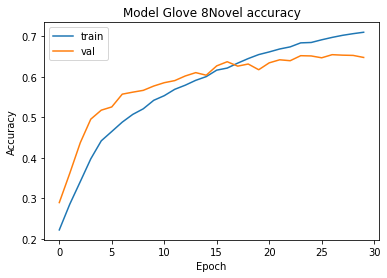

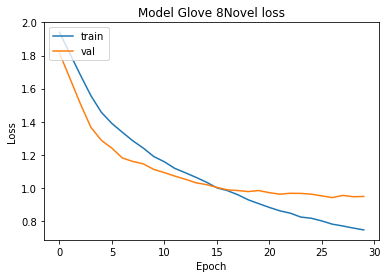

In [ ]:
plt.plot(hist_glove_new.history['accuracy'])
plt.plot(hist_glove_new.history['val_accuracy'])
plt.title('Model Glove 8Novel accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_new.history['loss'])
plt.plot(hist_glove_new.history['val_loss'])
plt.title('Model Glove 8Novel loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred_glove_new = model_glove_new.predict(test_padded_new)
sample_submission_new[['0','1','2','3','4','5','6','7']] = pred_glove_new
sample_submission_new

,index,0,1,2,3,4,5,6,7
0,0,0.000103,6.374757e-01,4.259563e-05,1.803017e-04,8.120294e-07,3.621443e-01,1.445226e-06,5.236645e-05
1,1,0.000048,1.361949e-01,1.126968e-06,1.261667e-05,4.130935e-08,8.634503e-01,7.221441e-06,2.859293e-04
2,2,0.000272,9.076676e-02,1.641013e-06,1.282083e-05,1.414887e-07,9.058434e-01,4.251874e-05,3.060344e-03
3,3,0.000030,9.032983e-02,2.273663e-07,2.602938e-06,9.629172e-09,9.092719e-01,5.860762e-06,3.591914e-04
4,4,0.010061,5.692779e-02,1.229339e-04,3.155888e-04,3.638938e-05,7.609578e-01,8.291190e-03,1.632868e-01
...,...,...,...,...,...,...,...,...,...
27313,27313,0.000007,9.999886e-01,7.920163e-08,3.729562e-06,1.133104e-09,3.040618e-07,3.051733e-18,2.866301e-11
27314,27314,0.002142,1.629217e-08,6.705129e-04,3.813934e-07,8.179168e-01,1.358860e-08,1.756284e-01,3.642051e-03
27315,27315,0.000011,9.999819e-01,3.027334e-07,6.615356e-06,4.304823e-09,6.486404e-07,3.794256e-17,7.783550e-11
27316,27316,0.000242,9.997060e-01,5.546931e-06,4.048135e-05,2.754918e-07,5.243317e-06,1.104074e-14,9.279016e-09


In [ ]:
model_glove_new.save('/content/drive/MyDrive/Novelist_Classification/model/CNN/cnn_glove_new.h5')

#GRU 모델 <br>
1. 단방향 GRU - fasttext

In [ ]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size
VOCAB_SIZE_new = vocab_size_new

In [ ]:
# 단방향 GRU - fasttext
from keras.optimizers import Adam
model_using_GRU_fasttext_one = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, 300, weights = [FT_embedding_matrix], input_length=max_length),
  tf.keras.layers.GRU(units=64, activation='relu'), # relu를 활용한 GRU
  tf.keras.layers.Dropout(dropout_prob),
  tf.keras.layers.Dense(2, activation='softmax'),
])

model_using_GRU_fasttext_one.compile(optimizer = Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model_using_GRU_fasttext_one.summary()

In [ ]:
# 단방향 GRU 학습 - fasttext
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# fit model
num_epochs = 20
hist_fast_gru_one = model_using_GRU_fasttext_one.fit(train_padded, y_train, 
                    epochs = num_epochs, verbose = 2,
                    validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 67s - loss: 1.5050 - accuracy: 0.3310 - val_loss: 1.3827 - val_accuracy: 0.3982
Epoch 2/30
1372/1372 - 63s - loss: 1.2246 - accuracy: 0.4786 - val_loss: 1.0830 - val_accuracy: 0.5606
Epoch 3/30
1372/1372 - 63s - loss: 0.9704 - accuracy: 0.6103 - val_loss: 0.9746 - val_accuracy: 0.6175
Epoch 4/30
1372/1372 - 62s - loss: 0.8013 - accuracy: 0.6933 - val_loss: 0.9007 - val_accuracy: 0.6589
Epoch 5/30
1372/1372 - 62s - loss: 0.6833 - accuracy: 0.7441 - val_loss: 0.8794 - val_accuracy: 0.6758
Epoch 6/30
1372/1372 - 62s - loss: 0.6035 - accuracy: 0.7780 - val_loss: 0.8955 - val_accuracy: 0.6803
Epoch 7/30
1372/1372 - 62s - loss: 0.5431 - accuracy: 0.7996 - val_loss: 0.9553 - val_accuracy: 0.6829
Epoch 8/30
1372/1372 - 62s - loss: 0.5024 - accuracy: 0.8164 - val_loss: 0.9141 - val_accuracy: 0.6923
Epoch 9/30
1372/1372 - 62s - loss: 0.4641 - accuracy: 0.8295 - val_loss: 1.0001 - val_accuracy: 0.6931
Epoch 10/30
1372/1372 - 62s - loss: 0.4420 - accuracy: 0.8413 - val_loss:

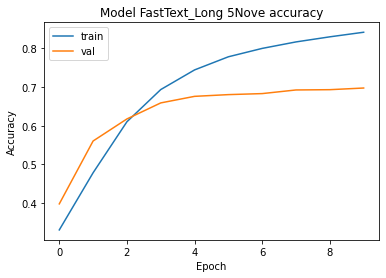

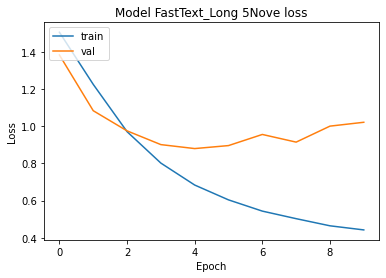

In [ ]:
plt.plot(hist_fast_gru_one.history['accuracy'])
plt.plot(hist_fast_gru_one.history['val_accuracy'])
plt.title('Fasttext GRU one-direction accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_gru_one.history['loss'])
plt.plot(hist_fast_gru_one.history['val_loss'])
plt.title('Fasttext GRU one-direction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save GRU
model_using_GRU_fasttext_one.save('/content/drive/MyDrive/Novelist_Classification/model/GRU/gru_fast_one.h5')

2. 단방향 GRU - glove

In [ ]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size
VOCAB_SIZE_new = vocab_size_new

In [ ]:
# 단방향 GRU - glove
from keras.optimizers import Adam
model_using_GRU_glove_one = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, 300, weights = [g_embedding_matrix], input_length=max_length),
  tf.keras.layers.GRU(units=64, activation='relu'), # relu를 활용한 GRU
  tf.keras.layers.Dropout(dropout_prob),
  tf.keras.layers.Dense(2, activation='softmax'),
])

model_using_GRU_glove_one.compile(optimizer = Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model_using_GRU_glove_one.summary()

In [ ]:
# 단방향 GRU 학습 - glove
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# fit model
num_epochs = 20
hist_glove_gru_one = model_using_GRU_glove_one.fit(train_padded, y_train, 
                    epochs = num_epochs, verbose = 2,
                    validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 67s - loss: 1.5050 - accuracy: 0.3310 - val_loss: 1.3827 - val_accuracy: 0.3982
Epoch 2/30
1372/1372 - 63s - loss: 1.2246 - accuracy: 0.4786 - val_loss: 1.0830 - val_accuracy: 0.5606
Epoch 3/30
1372/1372 - 63s - loss: 0.9704 - accuracy: 0.6103 - val_loss: 0.9746 - val_accuracy: 0.6175
Epoch 4/30
1372/1372 - 62s - loss: 0.8013 - accuracy: 0.6933 - val_loss: 0.9007 - val_accuracy: 0.6589
Epoch 5/30
1372/1372 - 62s - loss: 0.6833 - accuracy: 0.7441 - val_loss: 0.8794 - val_accuracy: 0.6758
Epoch 6/30
1372/1372 - 62s - loss: 0.6035 - accuracy: 0.7780 - val_loss: 0.8955 - val_accuracy: 0.6803
Epoch 7/30
1372/1372 - 62s - loss: 0.5431 - accuracy: 0.7996 - val_loss: 0.9553 - val_accuracy: 0.6829
Epoch 8/30
1372/1372 - 62s - loss: 0.5024 - accuracy: 0.8164 - val_loss: 0.9141 - val_accuracy: 0.6923
Epoch 9/30
1372/1372 - 62s - loss: 0.4641 - accuracy: 0.8295 - val_loss: 1.0001 - val_accuracy: 0.6931
Epoch 10/30
1372/1372 - 62s - loss: 0.4420 - accuracy: 0.8413 - val_loss:

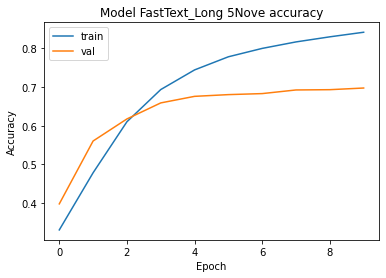

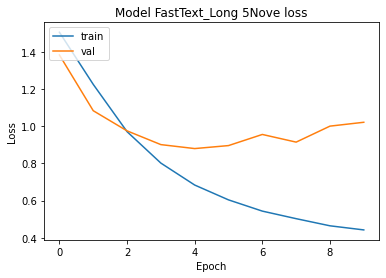

In [ ]:
plt.plot(hist_glove_gru_one.history['accuracy'])
plt.plot(hist_glove_gru_one.history['val_accuracy'])
plt.title('Glove GRU one-direction accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_gru_one.history['loss'])
plt.plot(hist_glove_gru_one.history['val_loss'])
plt.title('Glove GRU one-direction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save GRU
model_using_GRU_glove_one.save('/content/drive/MyDrive/Novelist_Classification/model/GRU/gru_glove_one.h5')

3. 양방향 GRU - fasttext

In [ ]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size
VOCAB_SIZE_new = vocab_size_new

In [ ]:
# 양방향 GRU - fasttext
from keras.optimizers import Adam
model_using_GRU_fasttext_bi = Sequential([
    Embedding(vocab_size, 300, weights = [FT_embedding_matrix] ,input_length = max_length),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(64)),
    tf.keras.layers.Dropout(dropout_prob),
    Dense(2, activation='softmax')
])
    
model_using_GRU_fasttext_bi.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=0.01))
model_using_GRU_fasttext_bi.summary()

In [ ]:
# 양방향 GRU 학습 - fasttext
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# fit model
num_epochs = 20
hist_fast_gru_bi = model_using_GRU_fasttext_bi.fit(train_padded, y_train, 
                    epochs = num_epochs, verbose = 2,
                    validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 67s - loss: 1.5050 - accuracy: 0.3310 - val_loss: 1.3827 - val_accuracy: 0.3982
Epoch 2/30
1372/1372 - 63s - loss: 1.2246 - accuracy: 0.4786 - val_loss: 1.0830 - val_accuracy: 0.5606
Epoch 3/30
1372/1372 - 63s - loss: 0.9704 - accuracy: 0.6103 - val_loss: 0.9746 - val_accuracy: 0.6175
Epoch 4/30
1372/1372 - 62s - loss: 0.8013 - accuracy: 0.6933 - val_loss: 0.9007 - val_accuracy: 0.6589
Epoch 5/30
1372/1372 - 62s - loss: 0.6833 - accuracy: 0.7441 - val_loss: 0.8794 - val_accuracy: 0.6758
Epoch 6/30
1372/1372 - 62s - loss: 0.6035 - accuracy: 0.7780 - val_loss: 0.8955 - val_accuracy: 0.6803
Epoch 7/30
1372/1372 - 62s - loss: 0.5431 - accuracy: 0.7996 - val_loss: 0.9553 - val_accuracy: 0.6829
Epoch 8/30
1372/1372 - 62s - loss: 0.5024 - accuracy: 0.8164 - val_loss: 0.9141 - val_accuracy: 0.6923
Epoch 9/30
1372/1372 - 62s - loss: 0.4641 - accuracy: 0.8295 - val_loss: 1.0001 - val_accuracy: 0.6931
Epoch 10/30
1372/1372 - 62s - loss: 0.4420 - accuracy: 0.8413 - val_loss:

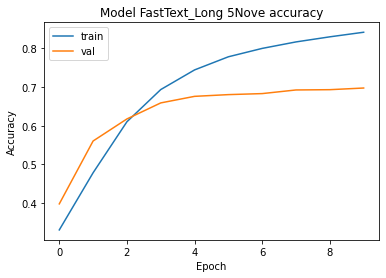

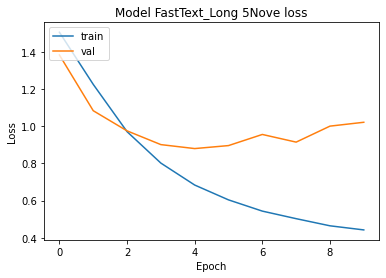

In [ ]:
plt.plot(hist_fast_gru_bi.history['accuracy'])
plt.plot(hist_fast_gru_bi.history['val_accuracy'])
plt.title('Fasttext GRU bi-direction accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_fast_gru_bi.history['loss'])
plt.plot(hist_fast_gru_bi.history['val_loss'])
plt.title('Fasttext GRU bi-direction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save GRU
model_using_GRU_fasttext_bi.save('/content/drive/MyDrive/Novelist_Classification/model/GRU/gru_fast_bi.h5')

4. 양방향 GRU - glove

In [ ]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 30
VOCAB_SIZE = vocab_size
VOCAB_SIZE_new = vocab_size_new

In [ ]:
# 단방향 GRU - glove
from keras.optimizers import Adam
model_using_GRU_glove_bi = Sequential([
    Embedding(vocab_size, 300, weights = [g_embedding_matrix] ,input_length = max_length),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(64)),
    tf.keras.layers.Dropout(dropout_prob),
    Dense(2, activation='softmax')
])
    
model_using_GRU_glove_bi.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=0.01))
model_using_GRU_glove_bi.summary()

In [ ]:
# 단방향 GRU 학습 - glove
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

# fit model
num_epochs = 20
hist_glove_gru_bi = model_using_GRU_glove_bi.fit(train_padded, y_train, 
                    epochs = num_epochs, verbose = 2,
                    validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/30
1372/1372 - 67s - loss: 1.5050 - accuracy: 0.3310 - val_loss: 1.3827 - val_accuracy: 0.3982
Epoch 2/30
1372/1372 - 63s - loss: 1.2246 - accuracy: 0.4786 - val_loss: 1.0830 - val_accuracy: 0.5606
Epoch 3/30
1372/1372 - 63s - loss: 0.9704 - accuracy: 0.6103 - val_loss: 0.9746 - val_accuracy: 0.6175
Epoch 4/30
1372/1372 - 62s - loss: 0.8013 - accuracy: 0.6933 - val_loss: 0.9007 - val_accuracy: 0.6589
Epoch 5/30
1372/1372 - 62s - loss: 0.6833 - accuracy: 0.7441 - val_loss: 0.8794 - val_accuracy: 0.6758
Epoch 6/30
1372/1372 - 62s - loss: 0.6035 - accuracy: 0.7780 - val_loss: 0.8955 - val_accuracy: 0.6803
Epoch 7/30
1372/1372 - 62s - loss: 0.5431 - accuracy: 0.7996 - val_loss: 0.9553 - val_accuracy: 0.6829
Epoch 8/30
1372/1372 - 62s - loss: 0.5024 - accuracy: 0.8164 - val_loss: 0.9141 - val_accuracy: 0.6923
Epoch 9/30
1372/1372 - 62s - loss: 0.4641 - accuracy: 0.8295 - val_loss: 1.0001 - val_accuracy: 0.6931
Epoch 10/30
1372/1372 - 62s - loss: 0.4420 - accuracy: 0.8413 - val_loss:

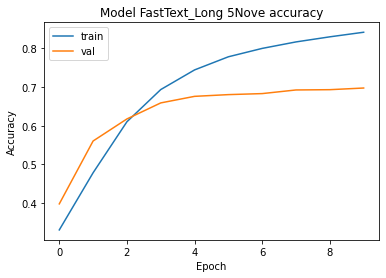

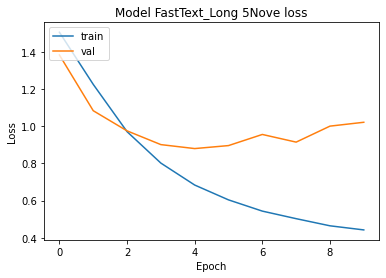

In [ ]:
plt.plot(hist_glove_gru_bi.history['accuracy'])
plt.plot(hist_glove_gru_bi.history['val_accuracy'])
plt.title('Glove GRU one-direction accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(hist_glove_gru_bi.history['loss'])
plt.plot(hist_glove_gru_bi.history['val_loss'])
plt.title('Glove GRU one-direction loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save GRU
model_using_GRU_glove_bi.save('/content/drive/MyDrive/Novelist_Classification/model/GRU/gru_glove_bi.h5')